In [12]:
import os
import warnings
warnings.filterwarnings('ignore')

In [13]:
base_dir='/kaggle/input/flood-area-segmentation'
print('No of images: ', len(os.listdir(os.path.join(base_dir,'Image'))))
print('No of masks: ',len(os.listdir(os.path.join(base_dir,'Mask'))))

No of images:  290
No of masks:  290


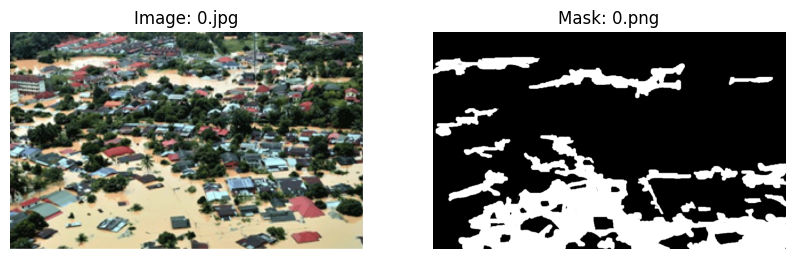

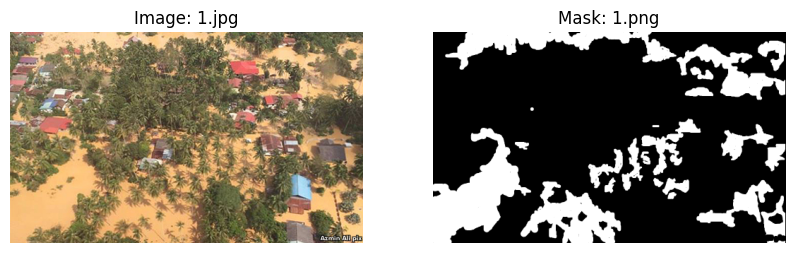

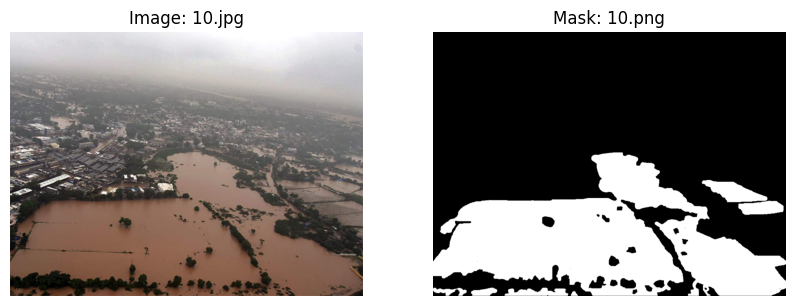

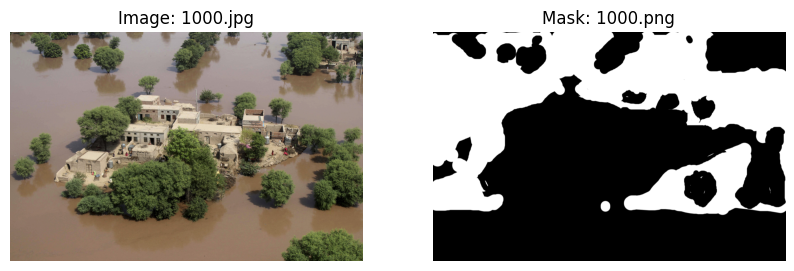

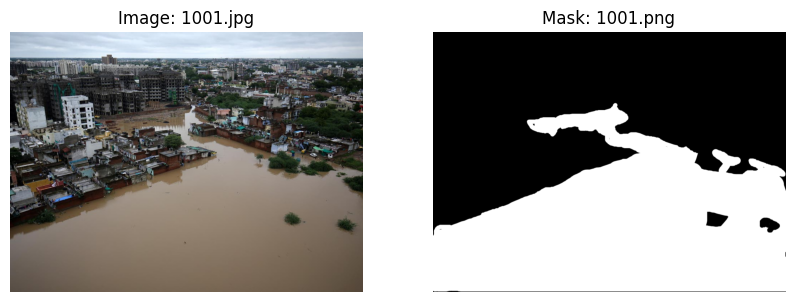

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image_dir = os.path.join(base_dir, 'Image')
mask_dir = os.path.join(base_dir, 'Mask')

def visualize_images_and_masks(num_images=5):
    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"Image: {img_file}")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Mask: {mask_file}")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.show()

# Call the function
visualize_images_and_masks()

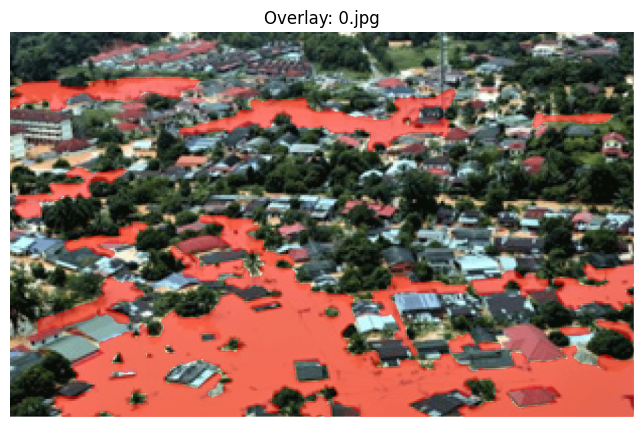

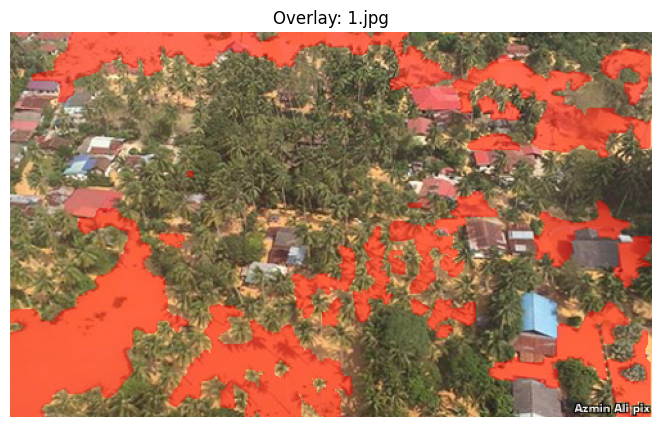

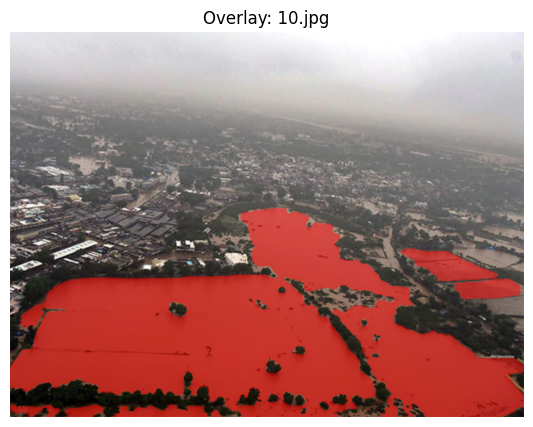

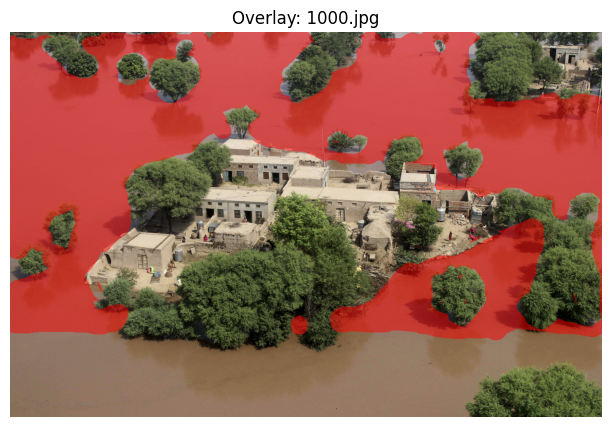

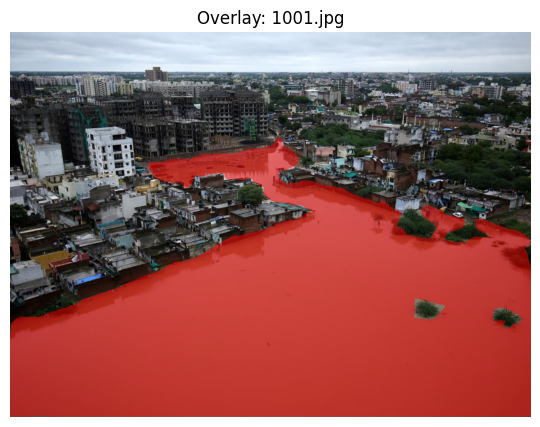

In [15]:
def overlay_mask_on_image(num_images=5, alpha=0.5):
    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Convert to numpy arrays
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Create overlay by blending image and mask
        overlay = img_np.copy()
        overlay[mask_np > 0] = [255, 0, 0]  # Highlight mask area in red

        blended = (1 - alpha) * img_np + alpha * overlay
        blended = blended.astype(np.uint8)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.title(f"Overlay: {img_file}")
        plt.imshow(blended)
        plt.axis('off')
        plt.show()

# Call the function
overlay_mask_on_image()


# Segmentation

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

In [17]:
IMG_HEIGHT, IMG_WIDTH = 224, 224 
BATCH_SIZE = 32

def load_images_and_masks():
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and resize
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
        mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")  # Grayscale

        # Normalize image and mask
        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

# Load dataset
images, masks = load_images_and_masks()
print(f"Loaded {len(images)} images and masks.")


Loaded 290 images and masks.


In [18]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
X_train.shape,X_val.shape

((232, 224, 224, 3), (58, 224, 224, 3))

In [19]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Create model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 224, 224,  │      2,320 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 112, 112,  │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 56, 56,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 56, 56,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 56, 56,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 192)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │    110,656 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 112, 112,  │          0 │ conv2d_24[0][0] 

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step - accuracy: 0.5390 - loss: 0.7125 - val_accuracy: 0.5714 - val_loss: 0.6894
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.5940 - loss: 0.6896 - val_accuracy: 0.5736 - val_loss: 0.6819
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.5714 - loss: 0.6829 - val_accuracy: 0.5737 - val_loss: 0.6688
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.5605 - loss: 0.6557 - val_accuracy: 0.6157 - val_loss: 0.5671
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.6617 - loss: 0.5697 - val_accuracy: 0.6832 - val_loss: 0.5828
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 0.7054 - loss: 0.5657 - val_accuracy: 0.7199 - val_loss: 0.5504
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 0.7228 - loss: 0.5347 - val_accuracy: 0.7604 - val_loss: 0.4794
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 0.7666 - loss: 0.4731 - val_accuracy: 0.7229 - val_loss: 0.5399
Epoch 9/

In [ ]:
model.save("flood_segmentation_model.h5")


In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()



In [ ]:
# Visualize predictions
def visualize_predictions(num_images=5):
    preds = model.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_val[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')

        plt.show()

visualize_predictions()
